# Finding Top Crypto Portfolios Using Coinbase Pro API

Adapted from original publication by [Brick Pop](https://medium.com/@brickpop):

[Finding top crypto portfolios with Tensorflow and Matrix calculus — Part #2](https://medium.com/stack-me-up/crypto-portfolio-optimization-with-python-and-tensorflow-matrix-calculus-approach-2-898c4d2019e8)

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import math
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
coins = {}
coin_history = {}
hist_length = 0
average_returns = {}
cumulative_returns = {}

# Adjust these two variables based on your currency and
# time frame you are looking to trade in.
primary_quote = 'BTC-USD'
quote_currecy = 'USD'
granularity = 86400 # {60, 300, 900, 3600, 21600, 86400}

# Not sure a start date is needed?
start_date = '2020-08-17' # 2021-02-01

def fetch_coins():
    url = 'https://api.pro.coinbase.com/products'
    response = requests.get(url)
    data = pd.DataFrame(json.loads(response.text))
    data = data[data['quote_currency'] == quote_currecy]
    #data = data.set_index('id')
    return data['id'].values

def fetch_all(coins):
    for coin in coins:
        coin_history[coin] = fetch_history(coin)

def fetch_history(coin):
    # Not sure start parameter is needed
    # url = f'https://api.pro.coinbase.com/products/{coin}/candles?granularity={granularity}&start={start_date}'
    url = f'https://api.pro.coinbase.com/products/{coin}/candles?granularity={granularity}'
    response = requests.get(url)
    if response.status_code == 200:  # check to make sure the response from server is good
        hist = pd.DataFrame(json.loads(response.text), columns=['time', 'low', 'high', 'open', 'close', 'volume'])
        hist = index_history(hist)
        hist['vol_fiat'] = hist['volume'] * hist['close']      # multiply the coin volume by closing price to approximate fiat volume

        if hist is None:
            print("Did not return any data from Coinbase for this symbol")
        else:
            return hist
    else:
        print("Did not receieve OK response from Coinbase API")
        
def index_history(hist):
  # index by date so we can easily filter by a given timeframe
  hist = hist.set_index('time')
  hist.index = pd.to_datetime(hist.index, unit='s')
  return hist

coins = fetch_coins()

fetch_all(coins)

In [3]:
# Should be 300
hist_length = len(coin_history[primary_quote])

coin_history[primary_quote]

,low,high,open,close,volume,vol_fiat
time,,,,,,
2021-06-13,34780.57,37634.73,35557.32,37593.20,9032.604033,3.395645e+08
2021-06-12,34635.47,37448.00,37340.08,35557.33,14516.545563,5.161696e+08
2021-06-11,35944.00,37695.00,36694.91,37338.44,14142.193500,5.280474e+08
2021-06-10,35800.00,38425.67,37404.75,36694.05,19853.814189,7.285169e+08
2021-06-09,32408.53,37573.99,33402.13,37403.86,26040.897933,9.740301e+08
...,...,...,...,...,...,...
2020-08-22,11370.00,11693.16,11529.99,11672.93,7946.024653,9.275339e+07
2020-08-21,11480.00,11884.99,11864.26,11529.22,14865.378759,1.713862e+08
2020-08-20,11671.48,11892.16,11758.87,11864.26,8801.177503,1.044195e+08


In [4]:
# Drop coins that don't have enough data
new_coins = []
new_coin_hist = {}

for coin in coins:
    #print(f'coin: {coin}\tlen: {len(coin_history[coin])}')
    if (len(coin_history[coin]) == hist_length):
        new_coins.append(coin)
        new_coin_hist[coin] = coin_history[coin]

coins = new_coins
coin_history = new_coin_hist

#for coin in coins:
    #print(f'{coin}\t{len(coin_history[coin])}')

In [5]:
# Calculate returns and excess returns

def add_all_returns():
  for coin in coins:
    hist = coin_history[coin]
    hist['return'] = (hist['close'] - hist['open']) / hist['open']
    hist['return'] = hist['return'].fillna(0)
    average = hist["return"].mean()
    average_returns[coin] = average
    cumulative_returns[coin] = (hist["return"] + 1).prod() - 1
    hist['excess_return'] = hist['return'] - average
    coin_history[coin] = hist
  
add_all_returns()

# display data
cumulative_returns
#coin_history[primary_quote]

{'BCH-USD': 0.884634100509684,
 'COMP-USD': 0.6492150420838549,
 'XLM-USD': 1.9071764621424139,
 'ETH-USD': 4.654965509182192,
 'LINK-USD': 0.3191911053180969,
 'LTC-USD': 1.4844879171838339,
 'NMR-USD': -0.2850826897499965,
 'OMG-USD': 0.7486696618895414,
 'XTZ-USD': -0.21799572759686558,
 'ATOM-USD': 1.0100972735062608,
 'ALGO-USD': 0.7489813925116944,
 'OXT-USD': -0.47594250898597823,
 'ETC-USD': 6.49263136738272,
 'ZRX-USD': 0.47299534993145675,
 'DAI-USD': 0.003722523543130185,
 'KNC-USD': -0.05364961948506031,
 'EOS-USD': 0.2881783549949033,
 'MKR-USD': 3.3400658452890593,
 'BAND-USD': -0.5352954556188734,
 'BTC-USD': 2.048386482694779,
 'REP-USD': 0.18571705057212928,
 'DASH-USD': 0.6908678339418064}

In [6]:
# Excess matrix

excess_matrix = np.zeros((hist_length, len(coins)))

for i in range(0, hist_length):
  for idx, coin in enumerate(coins):
    #print(f'i: {i}\tidx: {idx}\tcoin: {coin}')
    excess_matrix[i][idx] = coin_history[coin].iloc[i]['excess_return']

# Display

pretty_matrix = pd.DataFrame(excess_matrix, columns = coins, index = coin_history[coins[0]].index)

pretty_matrix

,BCH-USD,COMP-USD,XLM-USD,ETH-USD,LINK-USD,LTC-USD,NMR-USD,OMG-USD,XTZ-USD,ATOM-USD,...,ETC-USD,ZRX-USD,DAI-USD,KNC-USD,EOS-USD,MKR-USD,BAND-USD,BTC-USD,REP-USD,DASH-USD
time,,,,,,,,,,,,,,,,,,,,,
2021-06-13,0.015010,0.054618,0.022344,0.018082,0.021721,0.021927,-0.002395,0.023411,0.022109,0.028317,...,0.016292,-0.006945,0.000423,0.020887,0.020274,0.028538,0.029162,0.052671,0.022429,0.027173
2021-06-12,0.000077,0.000232,0.024066,-0.000551,0.005236,-0.011519,-0.015902,-0.033053,0.002204,-0.031620,...,-0.037535,-0.018234,-0.000346,-0.063923,-0.016805,-0.004660,-0.004630,-0.052329,-0.024390,-0.013288
2021-06-11,-0.046195,-0.105475,-0.067892,-0.054569,-0.076904,-0.038200,-0.052130,-0.066924,-0.045289,-0.076016,...,-0.028827,-0.080753,0.000261,-0.059420,-0.037378,-0.067601,-0.079111,0.012952,-0.079561,-0.032085
2021-06-10,-0.057528,-0.103429,-0.080712,-0.061044,-0.100031,-0.030153,-0.112882,-0.088704,-0.068673,-0.084112,...,-0.082958,-0.040982,0.000007,-0.112710,-0.052442,-0.074883,-0.085497,-0.023586,-0.024579,-0.042961
2021-06-09,0.061238,0.033054,0.038313,0.033214,0.057497,0.068469,0.076763,0.025977,0.017287,0.020713,...,0.088987,0.007731,0.000026,0.045913,0.053266,0.019791,0.096705,0.115219,0.021486,0.059184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-22,0.008552,0.021656,0.019154,0.012133,0.137252,0.014944,0.139162,-0.021033,0.054311,0.140219,...,0.013818,0.042963,-0.003279,0.041066,0.030600,0.054965,0.186994,0.007812,-0.132507,0.043821
2020-08-21,-0.044975,-0.059760,-0.078941,-0.074514,-0.142614,-0.064571,-0.105678,0.091322,-0.123112,-0.115944,...,-0.058784,0.126630,0.000351,-0.038880,-0.060127,-0.095330,-0.162790,-0.032825,0.531407,-0.057802
2020-08-20,0.001918,-0.019869,0.044001,0.012906,-0.012985,0.005589,0.110126,0.683076,0.060951,0.109455,...,0.013925,0.185780,-0.000380,0.071658,0.024213,0.009886,0.023911,0.004377,0.033195,0.037807


In [7]:
# Variance co-variance matrix

product_matrix = np.matmul(excess_matrix.transpose(), excess_matrix)
var_covar_matrix = product_matrix / hist_length

# Display

pretty_matrix = pd.DataFrame(var_covar_matrix, columns = coins, index = coins)

pretty_matrix

,BCH-USD,COMP-USD,XLM-USD,ETH-USD,LINK-USD,LTC-USD,NMR-USD,OMG-USD,XTZ-USD,ATOM-USD,...,ETC-USD,ZRX-USD,DAI-USD,KNC-USD,EOS-USD,MKR-USD,BAND-USD,BTC-USD,REP-USD,DASH-USD
BCH-USD,0.005810,0.003290,0.003916,0.003190,0.004038,0.003918,0.002399,0.004554,0.003968,0.003526,...,0.004895,0.003530,4.175514e-06,3.162957e-03,0.005078,0.003468,0.003605,0.002061,0.003180,0.004387
COMP-USD,0.003290,0.005910,0.003328,0.003133,0.003865,0.002855,0.002663,0.003782,0.003311,0.003597,...,0.002947,0.003892,1.487251e-05,3.366390e-03,0.003484,0.004003,0.004080,0.001737,0.002391,0.003292
XLM-USD,0.003916,0.003328,0.007956,0.002867,0.004064,0.003188,0.002392,0.004176,0.003996,0.003679,...,0.003499,0.003468,2.549134e-06,3.906882e-03,0.004640,0.003499,0.004052,0.001939,0.002526,0.003690
ETH-USD,0.003190,0.003133,0.002867,0.003418,0.003554,0.002971,0.002064,0.003469,0.002959,0.002980,...,0.002782,0.002913,1.427611e-05,2.658103e-03,0.003089,0.003234,0.003503,0.001759,0.002049,0.002837
LINK-USD,0.004038,0.003865,0.004064,0.003554,0.006192,0.003697,0.002952,0.004685,0.004271,0.004347,...,0.003653,0.004197,9.410422e-06,3.887776e-03,0.004235,0.003863,0.005232,0.001989,0.002704,0.003903
LTC-USD,0.003918,0.002855,0.003188,0.002971,0.003697,0.004219,0.002231,0.003894,0.003282,0.002985,...,0.003624,0.003036,6.526380e-06,2.952660e-03,0.003780,0.002774,0.003485,0.002049,0.002376,0.003677
NMR-USD,0.002399,0.002663,0.002392,0.002064,0.002952,0.002231,0.006821,0.003767,0.002968,0.002890,...,0.002561,0.003156,-1.137915e-06,2.779333e-03,0.003234,0.002389,0.003008,0.001290,0.002096,0.003162
OMG-USD,0.004554,0.003782,0.004176,0.003469,0.004685,0.003894,0.003767,0.009524,0.004855,0.004737,...,0.004970,0.005244,5.170911e-06,4.391912e-03,0.005425,0.003618,0.004882,0.001954,0.003909,0.004813
XTZ-USD,0.003968,0.003311,0.003996,0.002959,0.004271,0.003282,0.002968,0.004855,0.004774,0.004101,...,0.003826,0.004116,3.990344e-06,3.752386e-03,0.004545,0.003108,0.004335,0.001715,0.002722,0.003796
ATOM-USD,0.003526,0.003597,0.003679,0.002980,0.004347,0.002985,0.002890,0.004737,0.004101,0.006633,...,0.002998,0.004352,3.835349e-06,3.757239e-03,0.003919,0.003410,0.004448,0.001759,0.002448,0.003513


In [8]:
# Standard Deviation

std_deviations = np.zeros((len(coins), 1))

for idx, coin in enumerate(coins):
  std_deviations[idx][0] = np.std(coin_history[coin]['return'])
  
# Display

pretty_matrix = pd.DataFrame(std_deviations, columns = ['Std Dev'], index = coins)

pretty_matrix

,Std Dev
BCH-USD,0.076222
COMP-USD,0.076875
XLM-USD,0.089196
ETH-USD,0.058464
LINK-USD,0.078692
LTC-USD,0.064954
NMR-USD,0.082588
OMG-USD,0.097590
XTZ-USD,0.069096
ATOM-USD,0.081441


In [9]:
# Std Deviation products matrix

sdev_product_matrix = np.matmul(std_deviations, std_deviations.transpose())


# Display

pretty_matrix = pd.DataFrame(sdev_product_matrix, columns = coins, index = coins)

pretty_matrix

,BCH-USD,COMP-USD,XLM-USD,ETH-USD,LINK-USD,LTC-USD,NMR-USD,OMG-USD,XTZ-USD,ATOM-USD,...,ETC-USD,ZRX-USD,DAI-USD,KNC-USD,EOS-USD,MKR-USD,BAND-USD,BTC-USD,REP-USD,DASH-USD
BCH-USD,0.005810,0.005860,0.006799,0.004456,0.005998,0.004951,0.006295,0.007438,0.005267,0.006208,...,0.006757,0.006282,0.000163,0.005929,0.006290,0.006253,0.006510,0.003177,0.005837,0.006028
COMP-USD,0.005860,0.005910,0.006857,0.004494,0.006049,0.004993,0.006349,0.007502,0.005312,0.006261,...,0.006814,0.006336,0.000164,0.005980,0.006344,0.006306,0.006565,0.003205,0.005887,0.006080
XLM-USD,0.006799,0.006857,0.007956,0.005215,0.007019,0.005794,0.007367,0.008705,0.006163,0.007264,...,0.007907,0.007351,0.000190,0.006938,0.007361,0.007317,0.007618,0.003718,0.006831,0.007054
ETH-USD,0.004456,0.004494,0.005215,0.003418,0.004601,0.003797,0.004828,0.005705,0.004040,0.004761,...,0.005182,0.004819,0.000125,0.004548,0.004825,0.004796,0.004993,0.002437,0.004477,0.004624
LINK-USD,0.005998,0.006049,0.007019,0.004601,0.006192,0.005111,0.006499,0.007680,0.005437,0.006409,...,0.006976,0.006486,0.000168,0.006121,0.006494,0.006455,0.006721,0.003280,0.006026,0.006223
LTC-USD,0.004951,0.004993,0.005794,0.003797,0.005111,0.004219,0.005364,0.006339,0.004488,0.005290,...,0.005758,0.005353,0.000138,0.005053,0.005360,0.005329,0.005547,0.002708,0.004974,0.005137
NMR-USD,0.006295,0.006349,0.007367,0.004828,0.006499,0.005364,0.006821,0.008060,0.005707,0.006726,...,0.007321,0.006807,0.000176,0.006424,0.006815,0.006775,0.007053,0.003443,0.006325,0.006531
OMG-USD,0.007438,0.007502,0.008705,0.005705,0.007680,0.006339,0.008060,0.009524,0.006743,0.007948,...,0.008651,0.008043,0.000208,0.007591,0.008053,0.008006,0.008335,0.004068,0.007474,0.007718
XTZ-USD,0.005267,0.005312,0.006163,0.004040,0.005437,0.004488,0.005707,0.006743,0.004774,0.005627,...,0.006125,0.005695,0.000147,0.005375,0.005702,0.005668,0.005901,0.002880,0.005292,0.005464
ATOM-USD,0.006208,0.006261,0.007264,0.004761,0.006409,0.005290,0.006726,0.007948,0.005627,0.006633,...,0.007219,0.006712,0.000174,0.006335,0.006721,0.006681,0.006955,0.003395,0.006237,0.006441


In [10]:
# Correlation matrix

correlation_matrix = var_covar_matrix / sdev_product_matrix

# Display

pretty_matrix = pd.DataFrame(correlation_matrix, columns = coins, index = coins)

pretty_matrix

,BCH-USD,COMP-USD,XLM-USD,ETH-USD,LINK-USD,LTC-USD,NMR-USD,OMG-USD,XTZ-USD,ATOM-USD,...,ETC-USD,ZRX-USD,DAI-USD,KNC-USD,EOS-USD,MKR-USD,BAND-USD,BTC-USD,REP-USD,DASH-USD
BCH-USD,1.000000,0.561390,0.576001,0.715813,0.673269,0.791408,0.381088,0.612180,0.753363,0.568022,...,0.724484,0.561975,0.025692,0.533473,0.807301,0.554603,0.553828,0.648766,0.544837,0.727753
COMP-USD,0.561390,1.000000,0.485363,0.697042,0.638949,0.571668,0.419494,0.504080,0.623364,0.574561,...,0.432461,0.614322,0.090735,0.562959,0.549250,0.634797,0.621431,0.541877,0.406170,0.541496
XLM-USD,0.576001,0.485363,1.000000,0.549872,0.578950,0.550184,0.324736,0.479726,0.648441,0.506497,...,0.442507,0.471745,0.013404,0.563096,0.630426,0.478187,0.531977,0.521379,0.369771,0.523097
ETH-USD,0.715813,0.697042,0.549872,1.000000,0.772519,0.782389,0.427568,0.608079,0.732396,0.625795,...,0.536766,0.604628,0.114524,0.584497,0.640247,0.674398,0.701567,0.721689,0.457619,0.613551
LINK-USD,0.673269,0.638949,0.578950,0.772519,1.000000,0.723230,0.454249,0.610061,0.785581,0.678294,...,0.523655,0.647091,0.056086,0.635142,0.652203,0.598440,0.778429,0.606417,0.448644,0.627138
LTC-USD,0.791408,0.571668,0.550184,0.782389,0.723230,1.000000,0.415826,0.614324,0.731287,0.564271,...,0.629443,0.567054,0.047124,0.584390,0.705102,0.520581,0.628299,0.756682,0.477673,0.715769
NMR-USD,0.381088,0.419494,0.324736,0.427568,0.454249,0.415826,1.000000,0.467357,0.520171,0.429689,...,0.349879,0.463714,-0.006462,0.432633,0.474532,0.352597,0.426480,0.374607,0.331397,0.484128
OMG-USD,0.612180,0.504080,0.479726,0.608079,0.610061,0.614324,0.467357,1.000000,0.720071,0.596039,...,0.574561,0.651971,0.024851,0.578559,0.673576,0.451934,0.585733,0.480222,0.523031,0.623586
XTZ-USD,0.753363,0.623364,0.648441,0.732396,0.785581,0.731287,0.520171,0.720071,1.000000,0.728777,...,0.624633,0.722762,0.027085,0.698156,0.797073,0.548294,0.734569,0.595250,0.514492,0.694766
ATOM-USD,0.568022,0.574561,0.506497,0.625795,0.678294,0.564271,0.429689,0.596039,0.728777,1.000000,...,0.415275,0.648419,0.022087,0.593095,0.583065,0.510397,0.639476,0.518190,0.392416,0.545470


In [11]:
# PLOTTING

def line_plot(line1, label1=None, units='', title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.set_ylabel(units, fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

def lines_plot(line1, line2, label1=None, label2=None, units='', title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel(units, fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

def pie_chart(values, padding = 0.05, labels=None, title=''):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.pie(values, np.full(len(coins), padding), labels, autopct='%.2f')
    ax.set_title(title, fontsize=18)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[round 0]
Volatility 5.51%
Return 138.51%
Sharpe ratio 25.126810925577637

[round 2000]
Volatility 6.03%
Return 527.19%
Sharpe ratio 87.44150674337249

[round 4000]
Volatility 6.02%
Return 526.81%
Sharpe ratio 87.44408201839971

[round 6000]
Volatility 6.02%
Return 526.79%
Sharpe ratio 87.44477153707113

[round 8000]
Volatility 6.02%
Return 526.77%
Sharpe ratio 87.44511138205799

Volatility 6.02%
Return 525.84%
Sharpe ratio 87.32728870873738


,Weight
BCH-USD,0.010032
COMP-USD,0.010065
XLM-USD,0.010049
ETH-USD,66.522649
LINK-USD,0.010058
LTC-USD,0.010060
NMR-USD,0.010032
OMG-USD,0.010038
XTZ-USD,0.010037
ATOM-USD,0.010063


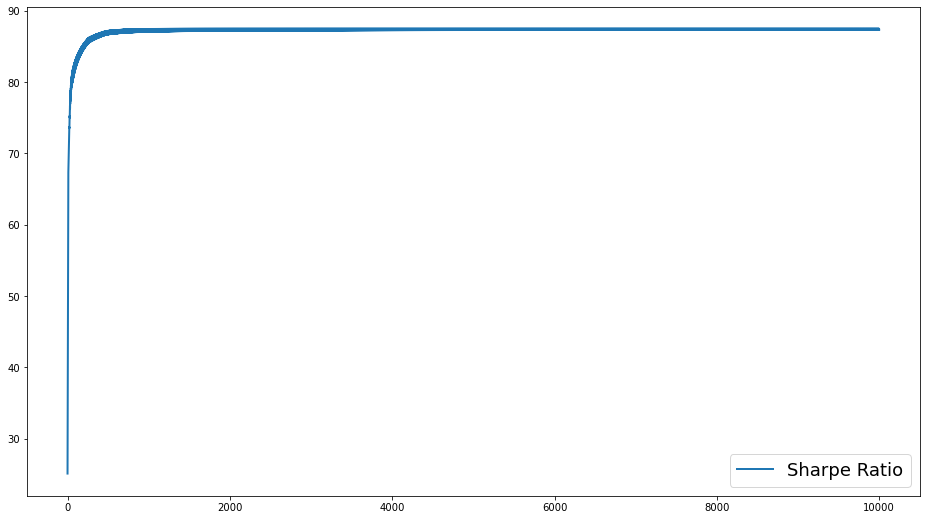

In [12]:
# Optimize weights to maximize return/risk

def maximize_sharpe_ratio():
  
  # Define the model
  
  # 1) Variance
  
  coin_weights = tf.Variable(np.full((len(coins), 1), 1.0 / len(coins))) # our variables
  weighted_std_devs = tf.multiply(coin_weights, std_deviations)
  
  product_1 = tf.transpose(weighted_std_devs)
  product_2 = tf.matmul(product_1, correlation_matrix)
  portfolio_variance = tf.matmul(product_2, weighted_std_devs)
  
  portfolio_volatility = tf.reduce_sum(tf.sqrt(portfolio_variance))
  
  # 2) Return
  
  returns = np.full((len(coins), 1), 0.0) # same as coin_weights
  for coin_idx in range(0, len(coins)):
    returns[coin_idx] = cumulative_returns[coins[coin_idx]]
  
  portfolio_return = tf.reduce_sum(tf.multiply(coin_weights, returns))
  
  # 3) Return / Risk
  
  sharpe_ratio = tf.divide(portfolio_return, portfolio_volatility)
  
  # Constraints
  
  # all values positive, with unity sum
  weights_sum = tf.reduce_sum(coin_weights)
  constraints_op = coin_weights.assign(tf.divide(tf.abs(coin_weights), tf.abs(weights_sum) ))
  
  # Run
  learning_rate = 0.0001
  steps = 10000
  
  # Training to maximize performance
  
  #optimize_op = tf.train.GradientDescentOptimizer(learning_rate, use_locking=True).minimize(tf.negative(sharpe_ratio))
  #optimize_op = tf.train.GradientDescentOptimizer(learning_rate, use_locking=True).minimize(inv_sharpe_ratio)
  
  #2#optimize_op = tf.train.AdamOptimizer(learning_rate, use_locking=True).minimize(tf.negative(sharpe_ratio))
  #3#optimize_op = tf.train.AdamOptimizer(learning_rate=0.00005, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False).minimize(tf.negative(sharpe_ratio))
  optimize_op = tf.train.AdagradOptimizer(learning_rate=0.01, initial_accumulator_value=0.1, use_locking=False).minimize(tf.negative(sharpe_ratio))
  
  
  init = tf.global_variables_initializer()
  
  with tf.Session() as sess:
    ratios = np.zeros(steps)
    returns = np.zeros(steps)
    sess.run(init)
    for i in range(steps):
      sess.run(optimize_op)
      sess.run(constraints_op)
      ratios[i] = sess.run(sharpe_ratio)
      returns[i] = sess.run(portfolio_return) * 100
      if i % 2000 == 0 : 
        sess.run(constraints_op)
        print("[round {:d}]".format(i))
        #print("Coin weights", sess.run(coin_weights))
        print("Volatility {:.2f}%".format(sess.run(portfolio_volatility)*100))
        print("Return {:.2f}%".format(sess.run(portfolio_return)*100))
        print("Sharpe ratio", sess.run(sharpe_ratio))
        print("")
    
    line_plot(ratios, "Sharpe Ratio")
    #line_plot(returns, "Return")
    sess.run(constraints_op)
    # print("Coin weights", sess.run(coin_weights))
    print("Volatility {:.2f}%".format(sess.run(portfolio_volatility)*100))
    print("Return {:.2f}%".format(sess.run(portfolio_return)*100))
    print("Sharpe ratio", sess.run(sharpe_ratio))
    return sess.run(coin_weights)

weights = maximize_sharpe_ratio()

pretty_weights = pd.DataFrame(weights * 100)
pretty_weights.index = coins
pretty_weights.columns = ["Weight"]

pretty_weights

[round 0]
Volatility 5.68%
Return 78.49%
Sharpe ratio 13.809784060820425

[round 2000]
Volatility 5.24%
Return 425.83%
Sharpe ratio 81.19979780886327

[round 4000]
Volatility 5.25%
Return 436.95%
Sharpe ratio 83.24888694245882

[round 6000]
Volatility 5.25%
Return 444.86%
Sharpe ratio 84.69160056016918

[round 8000]
Volatility 5.25%
Return 448.63%
Sharpe ratio 85.48376497472901

Volatility 5.24%
Return 451.11%
Sharpe ratio 86.0223737727979


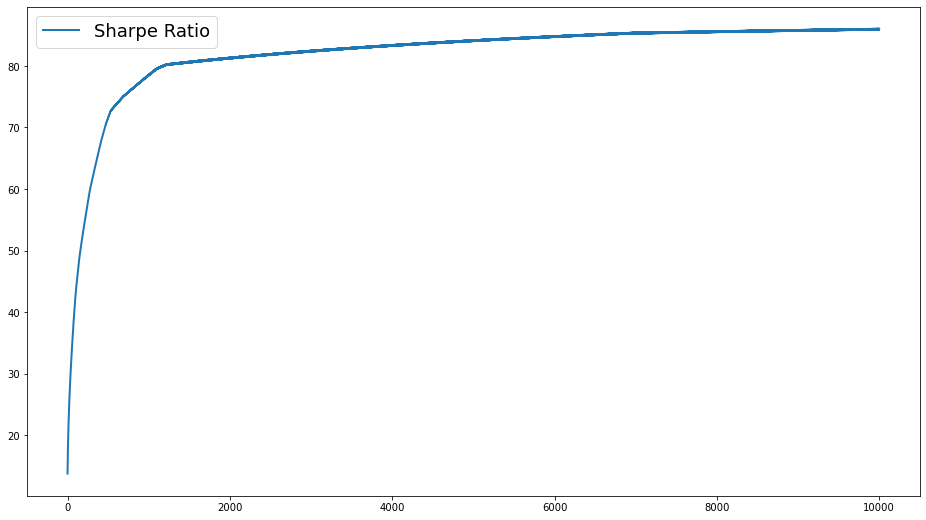

In [13]:
# Optimize weights to maximize return/risk

# Changed: inverse sharpe ratio, pie chart, random default weights, constraints

def maximize_sharpe_ratio():
  
  # Define the model
  
  # 1) Variance
  
  coin_weights = tf.Variable(tf.random_uniform((len(coins), 1), dtype=tf.float64)) # our variables
  weighted_std_devs = tf.multiply(coin_weights, std_deviations)
  
  product_1 = tf.transpose(weighted_std_devs)
  product_2 = tf.matmul(product_1, correlation_matrix)
  portfolio_variance = tf.matmul(product_2, weighted_std_devs)
  
  portfolio_volatility = tf.reduce_sum(tf.sqrt(portfolio_variance))
  
  # 2) Return
  
  returns = np.full((len(coins), 1), 0.0) # same as coin_weights
  for coin_idx in range(0, len(coins)):
    returns[coin_idx] = cumulative_returns[coins[coin_idx]]
  
  portfolio_return = tf.reduce_sum(tf.multiply(coin_weights, returns))
  
  # 3) Return / Risk
  
  sharpe_ratio = tf.divide(portfolio_return, portfolio_volatility)
  inv_sharpe_ratio = tf.divide(portfolio_volatility, portfolio_return)
  
  # Constraints
  
  # all values positive, with unity sum
  weights_sum = tf.reduce_sum(coin_weights)
  constraints_op = coin_weights.assign(tf.divide(tf.abs(coin_weights), tf.abs(weights_sum) ))
  
  # unity sum (allow from -1 to +1)
  #weights_sum = tf.reduce_sum(tf.abs(coin_weights))
  #constraints_op = coin_weights.assign(tf.divide(coin_weights, tf.abs(weights_sum) ))
  
  
  # Run
  learning_rate = 0.01
  steps = 10000
  
  # Training to maximize performance
  
  optimize_op = tf.train.GradientDescentOptimizer(learning_rate, use_locking=True).minimize(inv_sharpe_ratio)
  #2#optimize_op = tf.train.AdamOptimizer(learning_rate, use_locking=True).minimize(inv_sharpe_ratio)
  #3#optimize_op = tf.train.AdamOptimizer(learning_rate=0.00005, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False).minimize(inv_sharpe_ratio)
  #4#optimize_op = tf.train.AdagradOptimizer(learning_rate=0.01, initial_accumulator_value=0.1, use_locking=False).minimize(inv_sharpe_ratio)
  
  
  init = tf.global_variables_initializer()
  
  with tf.Session() as sess:
    ratios = np.zeros(steps)
    sess.run(init)
    for i in range(steps):
      sess.run(optimize_op)
      sess.run(constraints_op)
      ratios[i] = sess.run(sharpe_ratio)
      if i % 2000 == 0 : 
        sess.run(constraints_op)
        print("[round {:d}]".format(i))
        #print("Coin weights", sess.run(coin_weights))
        print("Volatility {:.2f}%".format(sess.run(portfolio_volatility)*100))
        print("Return {:.2f}%".format(sess.run(portfolio_return)*100))
        print("Sharpe ratio", sess.run(sharpe_ratio))
        print("")
    
    line_plot(ratios, "Sharpe Ratio")
    sess.run(constraints_op)
    # print("Coin weights", sess.run(coin_weights))
    print("Volatility {:.2f}%".format(sess.run(portfolio_volatility)*100))
    print("Return {:.2f}%".format(sess.run(portfolio_return)*100))
    print("Sharpe ratio", sess.run(sharpe_ratio))
    return sess.run(coin_weights)

weights = maximize_sharpe_ratio()

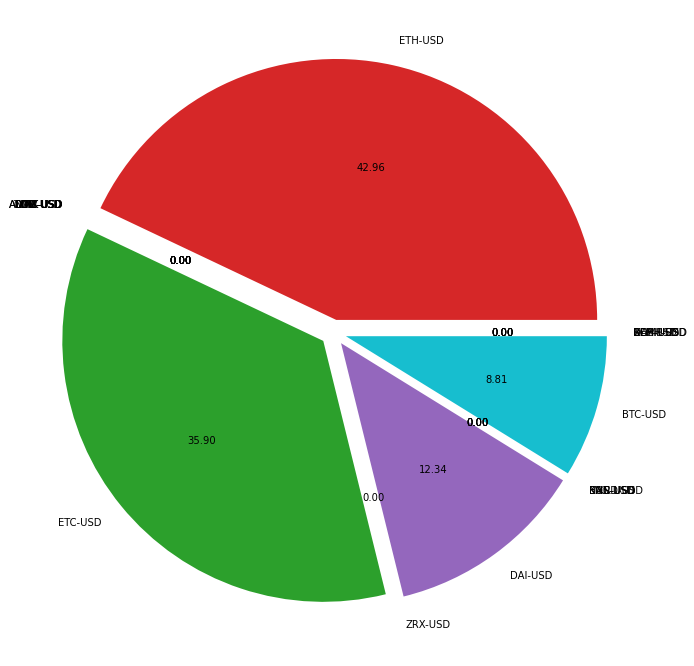

In [14]:
pie_chart(weights.flatten(), 0.05, coins)

In [15]:
# Refactor

def get_portfolio_volatility(coin_weights):
  weighted_std_devs = tf.multiply(coin_weights, std_deviations)

  product_1 = tf.transpose(weighted_std_devs)
  product_2 = tf.matmul(product_1, correlation_matrix)
  variance = tf.matmul(product_2, weighted_std_devs)

  volatility = tf.sqrt(variance)
  return tf.reduce_sum(volatility)

def get_portfolio_return(coin_weights):
  returns = np.full((len(coins), 1), 0.0) # same as coin_weights
  for coin_idx in range(0, len(coins)):
    returns[coin_idx] = cumulative_returns[coins[coin_idx]]
  
  p_return = tf.multiply(coin_weights, returns)
  return tf.reduce_sum(p_return)

def ensure_constraints_op(coin_weights):
  # all values positive, with unity sum
  weights_sum = tf.reduce_sum(coin_weights)
  constraints_op = coin_weights.assign(tf.divide(tf.abs(coin_weights), tf.abs(weights_sum) ))
  
  return constraints_op

def generate_max_sharpe_portfolio(learning_rate = 0.0001, steps = 2000, verbose = False):
  coin_weights = tf.Variable(tf.random_uniform((len(coins), 1), dtype=tf.float64)) # our variables

  portfolio_volatility = get_portfolio_volatility(coin_weights)
  portfolio_return = get_portfolio_return(coin_weights)
  
  sharpe_ratio = tf.divide(portfolio_return, portfolio_volatility)
  
  constraints_op = ensure_constraints_op(coin_weights)

  # Training using Gradient Descent to minimize cost
  #optimize_op = tf.train.GradientDescentOptimizer(learning_rate, use_locking=True).minimize(tf.negative(sharpe_ratio))
  optimize_op = tf.train.GradientDescentOptimizer(learning_rate, use_locking=True).minimize(tf.divide(1.0, sharpe_ratio))
  
  init_op = tf.global_variables_initializer()

  with tf.Session() as sess:
    ratios = np.zeros(steps)
    returns = np.zeros(steps)
    sess.run(init_op)
    
    for i in range(steps):
      sess.run(optimize_op)
      sess.run(constraints_op)
      ratios[i] = sess.run(sharpe_ratio)
      returns[i] = sess.run(portfolio_return) * 100
      
      if i % 500 == 0 and verbose : 
        sess.run(constraints_op)
        print("[round {:d}]".format(i))
        # print("Coin weights", sess.run(coin_weights))
        print("Volatility", sess.run(portfolio_volatility))
        print("Return {:.2f} %".format(sess.run(portfolio_return)*100))
        print("Sharpe ratio", sess.run(sharpe_ratio))
        print("")
        
    sess.run(constraints_op)
    
    if verbose :
      line_plot(ratios, "Sharpe Ratio")
      line_plot(returns, "Return")
      # print("Coin weights", sess.run(coin_weights))
      print("Volatility", sess.run(tf.reduce_sum(portfolio_volatility)))
      print("Return {:.2f} %".format(sess.run(portfolio_return)*100))
      print("Sharpe ratio", sess.run(tf.reduce_sum(sharpe_ratio)))
      
    return sess.run(coin_weights), sess.run(sharpe_ratio), sess.run(portfolio_return), sess.run(portfolio_volatility)

# example invocation

#weights1, sharpe1, return1, volatility1 = generate_max_sharpe_portfolio(learning_rate = 0.0015, steps = 20000, verbose = False)
#weights2, sharpe2, return2, volatility2 = generate_max_sharpe_portfolio(learning_rate = 0.005, steps = 2000)


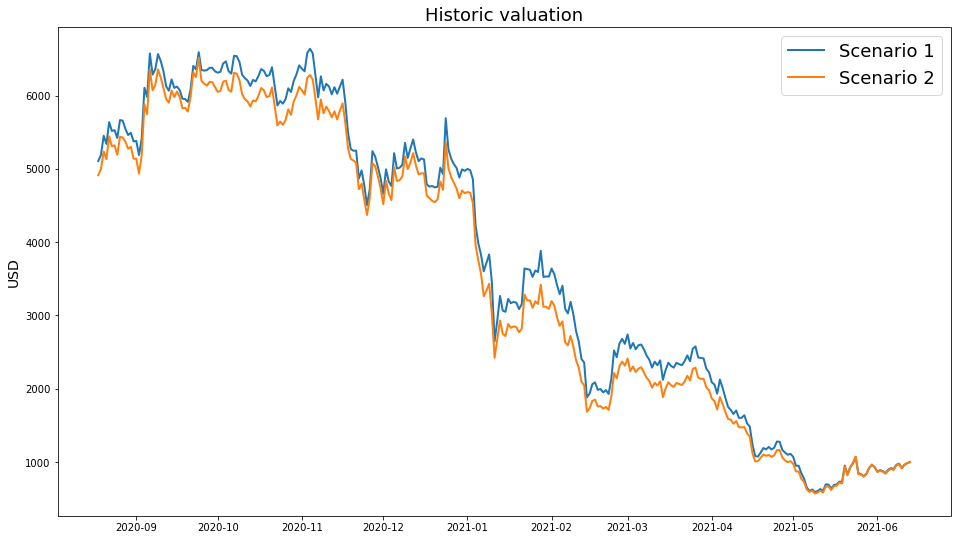

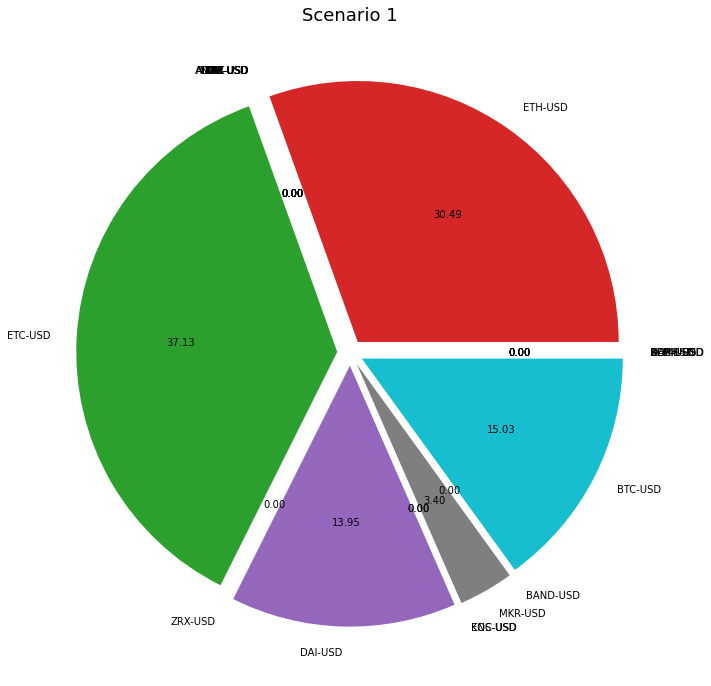

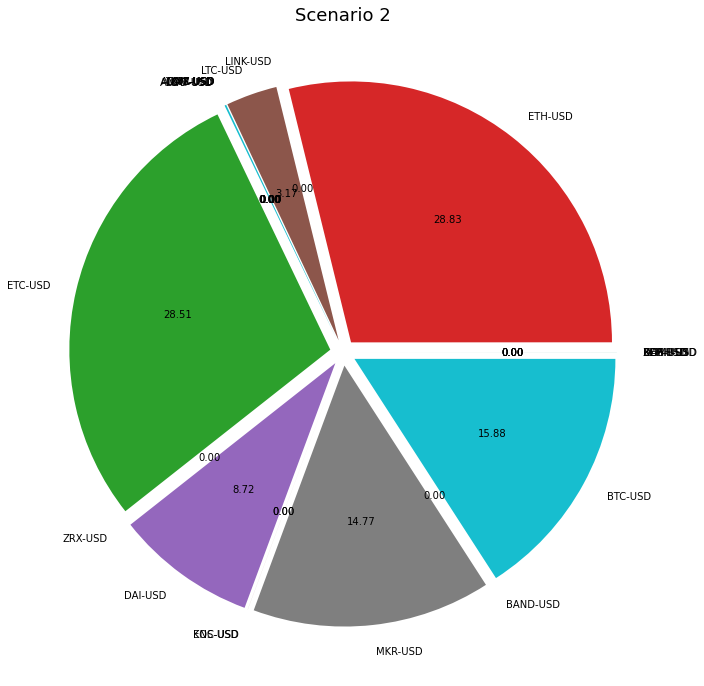

In [16]:
def get_cumulative_ratios_by_coin(weights):
  result = np.zeros((hist_length, len(coins)))
  result[0] = np.full(len(coins), 1)
  
  for i in range(1, hist_length):
    for idx, coin in enumerate(coins):
      result[i][idx] = result[i-1][idx] * (coin_history[coin].iloc[i]['return'] + 1)

  return result

def get_global_daily_valuation(weights):
  cumulative_ratios = get_cumulative_ratios_by_coin(weights)
  daily_cumulative_ratios = np.zeros(hist_length)
  for i in range(hist_length):
    daily_cumulative_ratios[i] = np.matmul(cumulative_ratios[i], weights)[0]
  
  return pd.DataFrame(daily_cumulative_ratios, columns = ["Cumulative return"], index = coin_history[coins[0]].index)

# Generate and plot

initial_capital = 1000

weights1, s1, r1, v1 = generate_max_sharpe_portfolio(learning_rate = 0.0015, steps = 20000)
weights2, s2, r2, v2 = generate_max_sharpe_portfolio(learning_rate = 0.005, steps = 2000)

returns1 = get_global_daily_valuation(weights1) * initial_capital
returns2 = get_global_daily_valuation(weights2) * initial_capital

lines_plot(returns1, returns2, "Scenario 1", "Scenario 2", "USD", "Historic valuation")
pie_chart(weights1.flatten(), 0.05, coins, "Scenario 1")
pie_chart(weights2.flatten(), 0.05, coins, "Scenario 2")


Generating portfolio  1
Generating portfolio  2
Generating portfolio  3
Generating portfolio  4
Generating portfolio  5
Generating portfolio  6
Generating portfolio  7
Generating portfolio  8
Generating portfolio  9
Generating portfolio  10
Generating portfolio  11
Generating portfolio  12
Generating portfolio  13
Generating portfolio  14
Generating portfolio  15
Generating portfolio  16
Generating portfolio  17
Generating portfolio  18
Generating portfolio  19
Generating portfolio  20


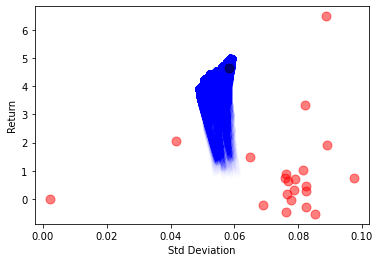

In [17]:
# Efficient Frontier

def generate_portfolios(count=20):
  coins_data = {
      "return": [],
      "volatility": []
  }
  portfolios_data = {
      "weights": [], # uncomment if you want to retrieve the coin weights
      "return": [],
      "volatility": []
  }
  
  # An entry for every coin alone
  for idx, coin in enumerate(coins):
    coins_data["volatility"].append(std_deviations[idx][0])
    coins_data["return"].append(cumulative_returns[coin])
    
  
  # N portfolios with their iterations
  for i in range(0, count):
    print("Generating portfolio ", i + 1)
    data = generate_portfolio_set(learning_rate = 0.01 * np.random.sample(), steps = int(15000 * np.random.sample()))
    #portfolios_data["weights"].extend(data['weights'])
    portfolios_data["return"].extend(data['return'])
    portfolios_data["volatility"].extend(data['volatility'])
    
  return coins_data, portfolios_data
  
def plot_efficient_frontier(coins_data, portfolios_data):
  plt.scatter(x=coins_data["volatility"], y=coins_data["return"], s=80, c="r", alpha=0.5)
  plt.scatter(x=portfolios_data["volatility"], y=portfolios_data["return"], s=30, c="b", alpha=0.002)
  plt.xlabel("Std Deviation")
  plt.ylabel("Return")
  plt.show()


def generate_portfolio_set(learning_rate = 0.0001, steps = 6000, verbose = False):
  result = {
      "weights": [],
      "return": [],
      "volatility": []
  }
  coin_weights = tf.Variable(tf.random_uniform((len(coins), 1), dtype=tf.float64)) # our variables

  portfolio_volatility = get_portfolio_volatility(coin_weights)
  portfolio_return = get_portfolio_return(coin_weights)
  
  sharpe_ratio = tf.divide(portfolio_return, portfolio_volatility)
  inv_sharpe_ratio = tf.divide(portfolio_volatility, portfolio_return)
  
  constraints_op = ensure_constraints_op(coin_weights)


  # Training using Gradient Descent to minimize cost
  optimize_op = tf.train.GradientDescentOptimizer(learning_rate, use_locking=True).minimize(inv_sharpe_ratio)
  
  init_op = tf.global_variables_initializer()

  with tf.Session() as sess:
    sess.run(init_op)
    for i in range(steps):
      sess.run(optimize_op)
      sess.run(constraints_op)
      result["return"].append(sess.run(portfolio_return))
      result["volatility"].append(sess.run(portfolio_volatility))
      result["weights"].append(sess.run(coin_weights))
      if i % 500 == 0 and verbose : 
        sess.run(constraints_op)
        print("[round {:d}]".format(i))
        #print("Coin weights", sess.run(coin_weights))
        print("Volatility", sess.run(portfolio_volatility))
        print("Return {:.2f} %".format(sess.run(portfolio_return)*100))
        print("Sharpe ratio", sess.run(sharpe_ratio))
        print("")
        
    sess.run(constraints_op)
    if verbose :
      line_plot(ratios, "Sharpe Ratio")
      line_plot(returns, "Return")
      # print("Coin weights", sess.run(coin_weights))
      print("Volatility", sess.run(tf.reduce_sum(portfolio_volatility)))
      print("Return {:.2f} %".format(sess.run(portfolio_return)*100))
      print("Sharpe ratio", sess.run(tf.reduce_sum(sharpe_ratio)))
    return result

  
coins_data, portfolios_data = generate_portfolios()

# Note:
# The leftmost red dot corresponds to the USDT stablecoin
# For a meaningful chart, remove USDT from the list of coins and rerun the code blocks again
plot_efficient_frontier(coins_data, portfolios_data)